In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sortedcontainers import SortedList
from datetime import datetime

# Utils

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

#def get_mnist():
mnist_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/lazyprogrammer/data/mnist.csv', header='infer')

if mnist_df.isna().sum().max() == 0:
  print('There is no NA values')
else:
  print(f'There are {mnist_df.isna().sum().max()} NAs' )

mnist_df.head()

Mounted at /content/gdrive/
There is no NA values


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
def plot_misclasified_examples(x, true_lables, predicted_lables, n=5, print_misclassified=False, labels=None):
  misclassified_idx = np.where(predicted_lables != true_lables)[0]
  misclassified_random_idxes = np.random.choice(misclassified_idx, n*n)
  plt.figure(figsize=(15,15))
  for i in range(n*n):
      idx = misclassified_random_idxes[i]
      plt.subplot(n,n,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(x[idx], cmap='gray')
      if labels==None:
        plt.xlabel("True  %s, Pred: %s" % (true_lables[idx], predicted_lables[idx]))
      else:
        plt.xlabel("True  %s, Pred: %s" % (labels[true_lables[idx]], labels[predicted_lables[idx]]))
  plt.show()

  if print_misclassified:
      if labels==None:
        print(pd.DataFrame({'idx':misclassified_random_idxes,
                        'true':true_lables[misclassified_random_idxes],
                        'pred':predicted_lables[misclassified_random_idxes]}))
      else:
        print(pd.DataFrame({'idx':misclassified_random_idxes,
                        #'true':labels[true_lables[misclassified_random_idxes]],
                        'true':true_lables[misclassified_random_idxes],
                        #'pred':labels[predicted_lables[misclassified_random_idxes]]}))
                        'pred':predicted_lables[misclassified_random_idxes]}))

def plot_examples(x, y, cmap='gray', labels=None):
  plt.figure(figsize=(15,15))
  for i in range(25):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(x[i], cmap=cmap)
      if labels==None:
        plt.xlabel(y[i])
      else:
        plt.xlabel(labels[y[i]])
  plt.show()

In [ ]:
def shuffle_pairs(X, Y):
  N = len(X)
  indexes = np.arange(N)
  np.random.shuffle(indexes)
  X = X[indexes]
  Y = Y[indexes]
  return X, Y


def get_mnist_data(should_shuffle = True, should_plot_examples=True):
  mnist_data = mnist_df.copy().values
  if (should_shuffle == True):
    np.random.shuffle(mnist_data)
  Y_mnist = mnist_data[:, 0]
  X_mnist = np.divide(mnist_data[:, 1:], 255.0)
  picture_shape = (28, 28)

  if (should_plot_examples == True):
    plot_examples(X_mnist.reshape((-1, *picture_shape)), Y_mnist, cmap='gray', labels=None)
  return X_mnist, Y_mnist, picture_shape


def get_xor_data(N=200, should_plot_data=True):
    X = np.zeros((N, 2))
    Nq = N // 4
    X[:Nq] = np.random.random((Nq, 2)) / 2 + 0.5 # (0.5-1, 0.5-1)
    X[Nq:(2*Nq)] = np.random.random((Nq, 2)) / 2 # (0-0.5, 0-0.5)
    X[(2*Nq):(3*Nq)] = np.random.random((Nq, 2)) / 2 + np.array([[0, 0.5]]) # (0-0.5, 0.5-1)
    X[(3*Nq):] = np.random.random((Nq, 2)) / 2 + np.array([[0.5, 0]]) # (0.5-1, 0-0.5)
    Y = np.array([0]*(N//2) + [1]*(N//2))

    X, Y = shuffle_pairs(X, Y)

    if (should_plot_data == True):
      plt.figure(figsize=(10,10))
      plt.scatter(X[:,0], X[:,1], c=Y, s=100, alpha=0.5);
      plt.title('Training data plot')
    return X, Y


def get_donut_data(N=200, should_plot_data=True):
    R_inner = 5
    R_outer = 10

    # distance from origin is radius + random normal
    # angle theta is uniformly distributed between (0, 2pi)
    R1 = np.random.randn(N//2) + R_inner
    theta = 2*np.pi*np.random.random(N//2)
    X_inner = np.concatenate([[R1 * np.cos(theta)], [R1 * np.sin(theta)]]).T

    R2 = np.random.randn(N//2) + R_outer
    theta = 2*np.pi*np.random.random(N//2)
    X_outer = np.concatenate([[R2 * np.cos(theta)], [R2 * np.sin(theta)]]).T

    X = np.concatenate([ X_inner, X_outer ])
    Y = np.array([0]*(N//2) + [1]*(N//2))
    
    X, Y = shuffle_pairs(X, Y)

    if (should_plot_data == True):
      plt.figure(figsize=(10,10))
      plt.scatter(X[:,0], X[:,1], c=Y, s=100, alpha=0.5);
      plt.title('Training data plot')
    return X, Y

# KNN model class

In [ ]:
def equides_metric(v1, v2):
  #print('v1:', v1)
  #print('v2:', v2)
  diff = (v1-v2)
  #print('diff:', diff)
  return np.sqrt(diff.dot(diff))


class KnnClassifier:
  def __init__(self, k, distance_metric=equides_metric):
    self._k = k
    self._distance_metric = distance_metric
  

  def fit(self, X, Y):
    self._X = X
    self._Y = Y
  
  
  def predict(self, X):
    X = np.array(X)
    train_shape = self._X.shape[1:]
    predict_shape = X.shape[1:]

    if (train_shape != predict_shape):
      raise ValueError(f'Data X used for prediction are in incorect shape. Expected shape for each observation is {train_shape}, but was {predict_shape}.') 

    X_dists = []
    for x in X:
      #print('x:', x)
      closest_neighbours = self._get_closest_neighbours(x)
      predicted_class = self._vote(closest_neighbours)
      X_dists.append(predicted_class)
    return np.array(X_dists)
  

  def _get_closest_neighbours(self, new_x):
    k_distances = SortedList()
    for i, x in enumerate(self._X):
      #print('i:', i)
      #print('x:', x)
      #print('new_x:', new_x)
      dist = self._distance_metric(new_x, x)
      
      #print(f'k_distances befor adding {dist}: {k_distances}')
      if (len(k_distances) < self._k):
        #print('(len(k_distances) < self._k)')
        k_distances.add((dist, self._Y[i]))
      else:
        last_dist = k_distances[-1][0]
        #print(f'else (last_dist:{last_dist}), (dist:{dist}), (diff last_dist-dist:{last_dist-dist})')
        if (dist == last_dist):
          #print('(dist == k_distances[-1][0])')
          k_distances.add((dist, self._Y[i]))
        if (dist < last_dist):
          #print('(dist < k_distances[-1][0])')
          k_distances.add((dist, self._Y[i]))
          
          #print('k_distances:', k_distances)
          k_th_dist, _ = k_distances[self._k-1]
          for i, (d, _) in enumerate(k_distances[self._k:]):
            if (d > k_th_dist):
              del k_distances[self._k+i:]
              break
          #print('k_th_dist:', k_th_dist)
      #print(f'k_distances after updating: {k_distances}')

    #print('k_distances:', k_distances)
    return k_distances


  def _vote(self, neighbours):
    #print('neighbours')
    #print(neighbours)
    df = pd.DataFrame(neighbours, columns=['distance', 'class'])
    #print('df:')
    #print(df)
    summary = df.groupby(by='class').agg({'class':'count', 'distance': 'sum'}).rename(columns={'class':'class_counts', 'distance':'distance_sum'}).reset_index()
    #print('summary:')
    #print(summary)
    sorted_df = summary.sort_values(by=['class_counts', 'distance_sum'], ascending=[False, True])
    #print('sorted_df:')
    #print(sorted_df)
    best_classes = sorted_df['class'].values
    #print(type(sorted_df['class']))
    #print('winner_class:', best_classes[0])
    return best_classes[0]


  def score(self, X, Y):
    predictions = self.predict(X)
    #print('predictions:', predictions)
    #print('true Y:', Y)
    return np.mean(predictions == Y)

# Run model utils

In [ ]:
def run_model(k, X, Y, N=2000):
  X_train, X_test = X[:N//2], X[N//2:N]
  Y_train, Y_test = Y[:N//2], Y[N//2:N]

  model = KnnClassifier(k)

  t0 = datetime.now()
  model.fit(X_train,Y_train)
  print(f'Fitted within {datetime.now()-t0} time')

  t0 = datetime.now()
  acc = model.score(X_train,Y_train)
  print(f'Predicted within {datetime.now()-t0} time with train accuracy={acc}')
  
  t0 = datetime.now()
  acc = model.score(X_test,Y_test)
  print(f'Predicted within {datetime.now()-t0} time with test accuracy={acc}')

# Use KnnClassifier for MNIST

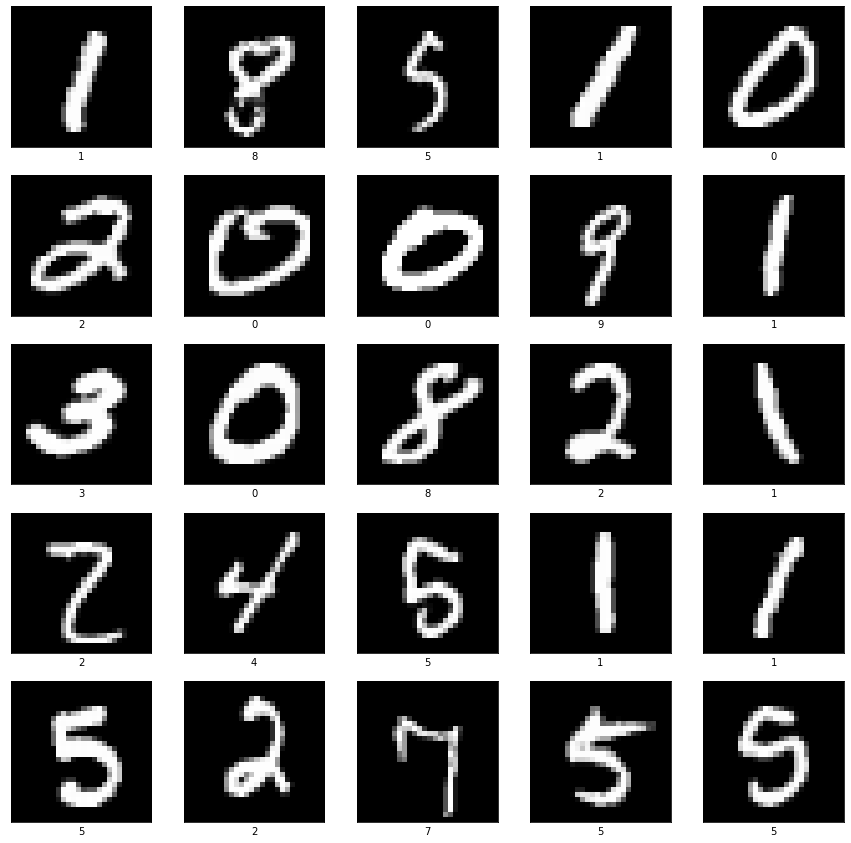

In [ ]:
X, Y, pic_shape = get_mnist_data()

In [ ]:
N = 2000
for k in range(1,6):
  print(f'{k}NN classifier')
  run_model(k, X.copy(), Y.copy(), N)

1NN classifier
Fitted within 0:00:00.000011 time
Predicted within 0:00:21.049441 time with train accuracy=1.0
Predicted within 0:00:21.024470 time with test accuracy=0.885
2NN classifier
Fitted within 0:00:00.000007 time
Predicted within 0:00:20.940159 time with train accuracy=1.0
Predicted within 0:00:20.984798 time with test accuracy=0.885
3NN classifier
Fitted within 0:00:00.000009 time
Predicted within 0:00:21.288290 time with train accuracy=0.959
Predicted within 0:00:21.022756 time with test accuracy=0.882
4NN classifier
Fitted within 0:00:00.000009 time
Predicted within 0:00:21.049151 time with train accuracy=0.955
Predicted within 0:00:21.391320 time with test accuracy=0.886
5NN classifier
Fitted within 0:00:00.000006 time
Predicted within 0:00:21.314440 time with train accuracy=0.938
Predicted within 0:00:21.429781 time with test accuracy=0.875


# Use KnnClassifier for Donut

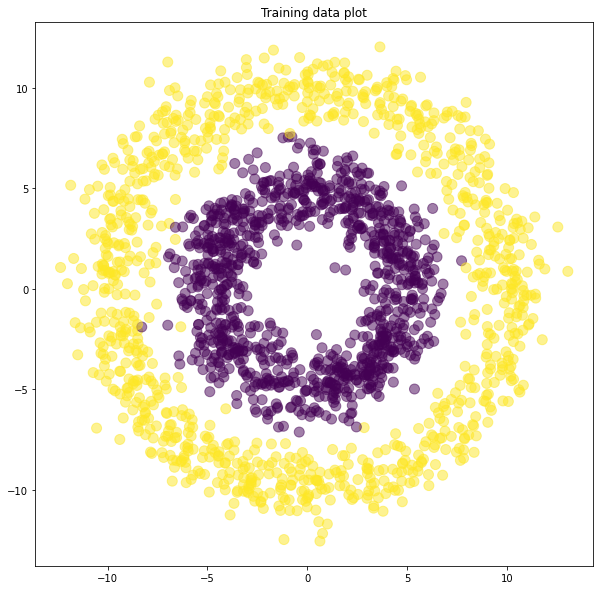

In [ ]:
N = 2000
X, Y = get_donut_data(N)

In [ ]:
for k in range(1,6):
  print(f'{k}NN classifier')
  run_model(k, X.copy(), Y.copy(), N)

1NN classifier
Fitted within 0:00:00.000010 time
Predicted within 0:00:11.689256 time with train accuracy=1.0
Predicted within 0:00:11.582168 time with test accuracy=0.99
2NN classifier
Fitted within 0:00:00.000007 time
Predicted within 0:00:11.736257 time with train accuracy=1.0
Predicted within 0:00:11.703950 time with test accuracy=0.99
3NN classifier
Fitted within 0:00:00.000015 time
Predicted within 0:00:11.861948 time with train accuracy=0.997
Predicted within 0:00:11.675002 time with test accuracy=0.989
4NN classifier
Fitted within 0:00:00.000010 time
Predicted within 0:00:11.903444 time with train accuracy=0.999
Predicted within 0:00:11.872017 time with test accuracy=0.991
5NN classifier
Fitted within 0:00:00.000008 time
Predicted within 0:00:11.908904 time with train accuracy=0.997
Predicted within 0:00:12.005765 time with test accuracy=0.992


# Use KnnClassifier for XOR

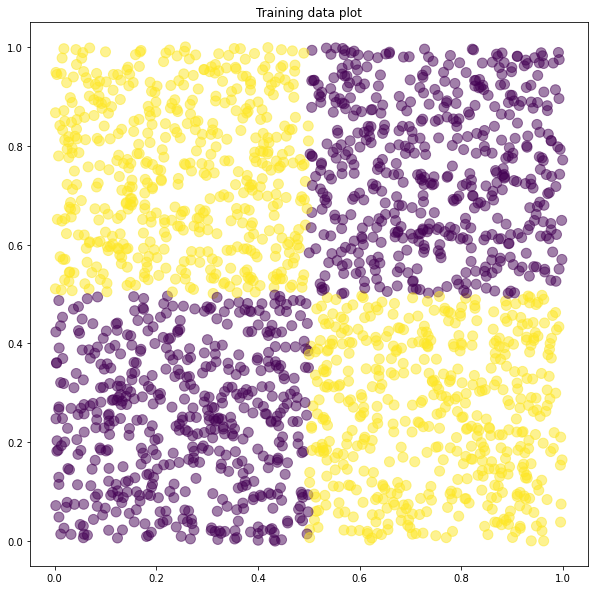

In [ ]:
N = 2000
X, Y = get_xor_data(N)

In [ ]:
for k in range(1,6):
  print(f'{k}NN classifier')
  run_model(k, X.copy(), Y.copy(), N)

1NN classifier
Fitted within 0:00:00.000015 time
Predicted within 0:00:11.702007 time with train accuracy=1.0
Predicted within 0:00:11.458053 time with test accuracy=0.989
2NN classifier
Fitted within 0:00:00.000011 time
Predicted within 0:00:11.894428 time with train accuracy=1.0
Predicted within 0:00:11.483613 time with test accuracy=0.989
3NN classifier
Fitted within 0:00:00.000008 time
Predicted within 0:00:11.860122 time with train accuracy=0.988
Predicted within 0:00:11.928248 time with test accuracy=0.983
4NN classifier
Fitted within 0:00:00.000011 time
Predicted within 0:00:11.968759 time with train accuracy=0.995
Predicted within 0:00:11.682760 time with test accuracy=0.989
5NN classifier
Fitted within 0:00:00.000008 time
Predicted within 0:00:11.954404 time with train accuracy=0.987
Predicted within 0:00:11.917624 time with test accuracy=0.984


# Example when KNN fials

In [ ]:
def get_knn_fail_data(D=20, should_plot_data=True):
    N = D * D
    X = []
    Y = []
    for i in range(D):
      for j in range(D):
        X.append([i,j])
        target = (i % 2 + j % 2) % 2
        Y.append(target) 
    X = np.array(X)
    Y = np.array(Y)

    #X, Y = shuffle_pairs(X, Y)

    if (should_plot_data == True):
      plt.figure(figsize=(10,10))
      plt.scatter(X[:,0], X[:,1], c=Y, s=100, alpha=0.5);
      plt.title('Training data plot')
    return X, Y

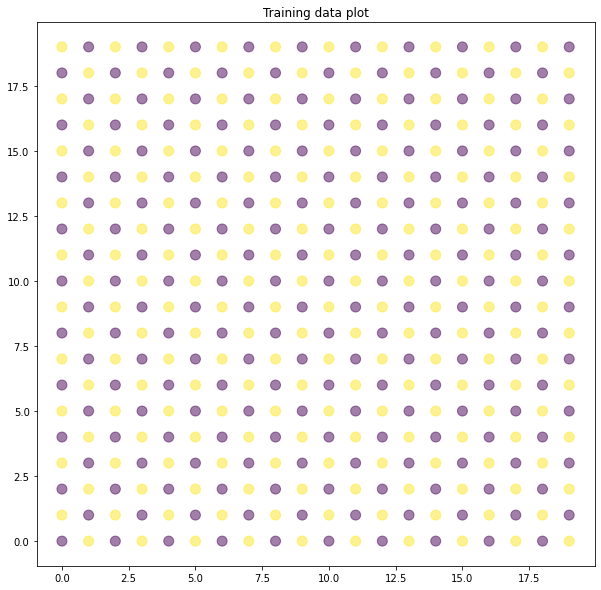

In [ ]:
X, Y = get_knn_fail_data(20)

In [ ]:
print(f'{3}NN classifier')
model = KnnClassifier(3)

t0 = datetime.now()
model.fit(X.copy(),Y.copy())
print(f'Fitted within {datetime.now()-t0} time')

t0 = datetime.now()
acc = model.score(X.copy(),Y.copy())
print(f'Predicted within {datetime.now()-t0} time with train accuracy={acc}')

3NN classifier
Fitted within 0:00:00.000012 time
Predicted within 0:00:03.844849 time with train accuracy=0.0
Predicted within 0:00:03.850231 time with test accuracy=0.0
